In [1]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap
import cProfile, pstats

from kuaizi.display import display_single

In [2]:
from astropy.io import fits

## Try gaap with reference catalog

In [138]:
# Load Merian catalog as reference
filt = 'N708'
tract = 9813
patch = 32
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)
refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)[:4000]
refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

# refCatInBand = butler.get(
#     'deepCoadd_ref',
#     collections='DECam/runs/merian/dr1_wide',
#     dataId=dataId,
#     instrument='DECam',
#     skymap='hsc_rings_v1',
# )[:4000]

refCatInBand = lsst.afw.table.SourceCatalog.readFits(
    '/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/deblendedFlux-HSC-G-9813-5,3.fits')

expID = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1')

In [123]:
exposure = lsst.afw.image.ExposureF(
    f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits")
# exposure = lsst.afw.image.ExposureF(
#     "/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/1/i/deepCoadd_calexp_9813_1_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits")
# exposure = lsst.afw.image.ExposureF(
#     "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_calexp/9813/79/N708/deepCoadd_calexp_9813_79_N708_hsc_rings_v1_DECam_runs_merian_dr1_wide_20220921T193246Z.fits")

In [126]:
measureConfig = lsst.meas.base.ForcedPhotCoaddConfig()
measureConfig.footprintDatasetName = 'DeblendedFlux'

measureConfig.measurement.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.measurement.plugins.names.add("base_SdssShape")
measureConfig.measurement.plugins.names.add("base_SdssCentroid")
measureConfig.measurement.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = False
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0]

photTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema, config=measureConfig)

In [127]:
measCat, exposureID = photTask.generateMeasCat(exposureDataId=butler.registry.expandDataId(expID), 
                                               exposure=exposure, 
                                               refCat=refCat, 
                                               refCatInBand=refCatInBand, 
                                               refWcs=refExposure.wcs, 
                                               idPackerName='tract_patch', 
                                               footprintData=refCatInBand)

In [128]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
photTask.run(measCat, exposure, refCat=refCat, refWcs=refExposure.wcs, exposureId=exposureID)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = measCat.copy(deep=True).asAstropy()

# Starting the measureTask at  Mon Nov  7 18:13:14 2022


Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_25 because could not find ext_gaap_GaapFlux_1_15x_0_25_instFlux or ext_gaap_GaapFlux_1_15x_0_25_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_5 because could not find ext_gaap_GaapFlux_1_15x_0_5_instFlux or ext_gaap_GaapFlux_1_15x_0_5_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_0_75 because could not find ext_gaap_GaapFlux_1_15x_0_75_instFlux or ext_gaap_GaapFlux_1_15x_0_75_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_1_0 because could not find ext_gaap_GaapFlux_1_15x_1_0_instFlux or ext_gaap_GaapFlux_1_15x_1_0_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_1_5 because could not find ext_gaap_GaapFlux_1_15x_1_5_instFlux or ext_gaap_GaapFlux_1_15x_1_5_instFluxErr in apCorrMap
Cannot aperture correct ext_gaap_GaapFlux_1_15x_2_0 because could not find ext_gaap_GaapFlux_1_15x_2_0_instFlux or ext_gaap_GaapFlux_1_15x_2_0_instFluxErr

# Finished measureTask in 358.79 seconds.


[]

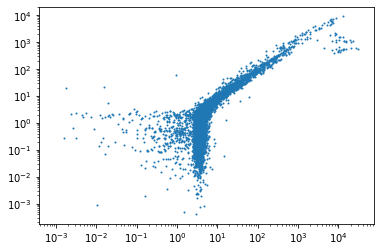

In [134]:
plt.scatter(refCat.asAstropy()['base_PsfFlux_instFlux'].data, cat2['base_PsfFlux_instFlux'].data, s=1)
plt.loglog()

In [97]:
measureConfig = lsst.meas.base.ForcedMeasurementConfig()
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins.names.add("base_SdssShape")
measureConfig.plugins.names.add("base_SdssCentroid")
measureConfig.plugins.names.add("ext_gaap_GaapFlux")
measureConfig.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = False
measureConfig.plugins["ext_gaap_GaapFlux"].sigmas = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 2.5, 3.0]
measureTask2 = lsst.meas.base.ForcedMeasurementTask(refSchema=refCat.schema, config=measureConfig)

In [98]:
catalog = measureTask2.generateMeasCat(exposure, refCat, refExposure.wcs, refCat.getIdFactory())
measureTask2.attachTransformedFootprints(catalog, refCat, refExposure, refExposure.wcs)

In [99]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
measureTask2.run(catalog, exposure, refCat=refCat, refWcs=refExposure.wcs)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = catalog.copy(deep=True).asAstropy()

# Starting the measureTask at  Fri Nov  4 16:42:34 2022


Failed to solve for PSF matching kernel in GAaP for (8066.511654, 3934.873622): Problematic scaling factors = 1.15 Errors: OutOfRangeError('Unable to insert a candidate at (8066.51, 3934.87)')
Failed to solve for PSF matching kernel in GAaP for (8045.248775, 3934.584972): Problematic scaling factors = 1.15 Errors: OutOfRangeError('Unable to insert a candidate at (8045.25, 3934.58)')
Failed to solve for PSF matching kernel in GAaP for (8084.550599, 3947.309115): Problematic scaling factors = 1.15 Errors: OutOfRangeError('Unable to insert a candidate at (8084.55, 3947.31)')
Failed to solve for PSF matching kernel in GAaP for (8066.240516, 3955.752187): Problematic scaling factors = 1.15 Errors: OutOfRangeError('Unable to insert a candidate at (8066.24, 3955.75)')
Failed to solve for PSF matching kernel in GAaP for (8054.336011, 3969.352270): Problematic scaling factors = 1.15 Errors: OutOfRangeError('Unable to insert a candidate at (8054.34, 3969.35)')
Failed to solve for PSF matching ke

KeyboardInterrupt: 

In [100]:
measTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema)

In [ ]:
refCat = 'deepCoadd_ref'
refCatInBand = 'deepCoadd_meas'

In [106]:
measTask.generateMeasCat(1, exposure, refCat, refCat, refExposure.wcs, 'tract_patch', refCat)

RuntimeError: A fully-expanded data ID is required; use Registry.expandDataId to obtain one.

[]

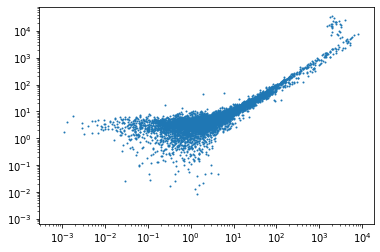

In [115]:
plt.scatter(measCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], refCat['ext_gaap_GaapFlux_1_15x_1_0_instFlux'], s=1)

plt.loglog()

[]

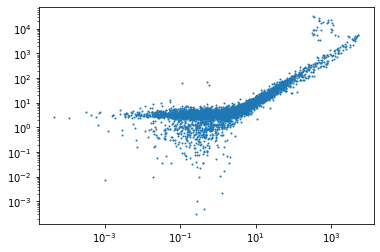

In [116]:
plt.scatter(measCat['base_PsfFlux_instFlux'], refCat['base_PsfFlux_instFlux'], s=1)

plt.loglog()

In [137]:
patch_old

'5,3'

In [117]:
import astropy.units as u

In [130]:
cat2['coord_ra'] = cat2['coord_ra'].to(u.deg)
cat2['coord_dec'] = cat2['coord_dec'].to(u.deg)

In [131]:
a = exposure.getPhotoCalib()

In [132]:
a.instFluxToNanojansky(1)

57.543993733715425

In [133]:
cat2.write('./my_own_gaap_s20a_32.fits', overwrite=True)

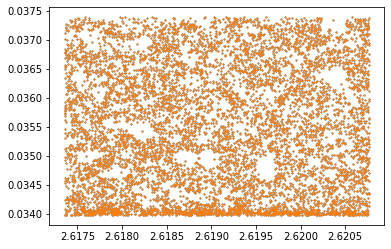

In [136]:
plt.scatter(measCat['coord_ra'], measCat['coord_dec'], s=1)
plt.scatter(refCat['coord_ra'], refCat['coord_dec'], s=1)

(array([1.73963134, 0.46082949, 1.50921659, 2.23502304, 2.00460829,
        0.94470046, 0.34562212, 0.17281106, 0.13824885, 0.0921659 ,
        0.02304147, 0.05760369, 0.06912442, 0.01152074, 0.04608295,
        0.03456221, 0.03456221, 0.04608295, 0.01152074, 0.02304147]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 [<matplotlib.patches.Polygon at 0x2b09a3a8be80>])

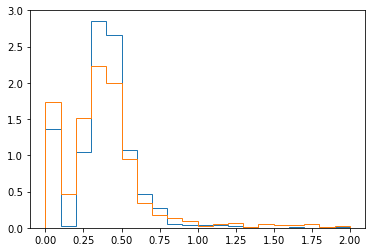

In [109]:
plt.hist(0.168 * ((cat2['base_SdssShape_xx'] * cat2['base_SdssShape_yy'] - cat2['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)

plt.hist(0.168 * ((refCat['base_SdssShape_xx'] * refCat['base_SdssShape_yy'] - refCat['base_SdssShape_xy']**2))**0.25,
         range=(0, 2), bins=20, histtype='step', density=True)

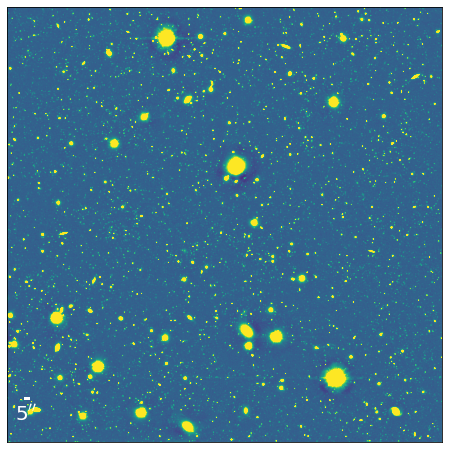

In [58]:
display_single(exposure.image.array);